# **Adding data to the Geoanalytics STAC server**

In this workflow we will leverage our knowledge on querying STAC servers and adding data to a STAC server. This workflow will find Sentinel-2 data from Planetary Computer, download it and access it's Metadata so as to allow us to add said data to our GeoAnalytics STAC server. These are the steps we will follow:
1. Write functions to query the STAC server, download the data, and create the STAC items
2. Apply our functions
3. Create a STAC Collection to which append our STAC items 
4. Add our completed collection to the GeoAnalytics STAC Server

In [ ]:
# We will use Sentinel-2 data from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer

In [37]:
import os
import json
import dask
import gcsfs
import pystac
import requests
import datetime
import stackstac
import rioxarray
import planetary_computer

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from dask_gateway import Gateway
from pystac_client import Client
from shapely.ops import unary_union
from IPython.display import clear_output
from dask.distributed import performance_report
from shapely.geometry import Polygon, mapping, shape
from pystac.extensions.projection import ProjectionExtension

In [39]:
gateway = Gateway()

# Cluster configuration
options = gateway.cluster_options()
options.image = 'pangeo/pangeo-notebook:2022.04.15'

In [ ]:
cluster = gateway.new_cluster(options)
cluster

In [157]:
# Scale the cluster
workers = 10
cluster.scale(workers)

In [158]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client()

In [ ]:
client.wait_for_workers(workers-1)
cluster

In [ ]:
gateway.list_clusters()

Remember to register for the gcsfs client, in order to access the Google Cloud Storage Buckets

In [1]:
def register_gcsfs_client(username: str):
    # set up the gcsfs system with credentials
    print('registering gcsfs')
    tok = os.path.join(os.environ['HOME'], f'geoanalytics_{username}',
                       'geo.json')  # Change this to your own cred file
    tok_dict = json.load(open(tok))
    gcs = gcsfs.GCSFileSystem(token=tok_dict, access='read_write')
    return gcs

In [ ]:
username = input('Username:')
gcs = register_gcsfs_client(username=username)

In [ ]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

In [46]:
# Create a polygon for defining our Area of Interest (AOI).
# In this case we created a polygon near Quebec City,Quebec using:
# https://www.keene.edu/campus/maps/tool/
polygon = {
  "coordinates": [
    [
      [
        -71.2405872,
        46.9847611
      ],
      [
        -71.2623882,
        46.9326235
      ],
      [
        -71.1655712,
        46.9171482
      ],
      [
        -71.145916,
        46.9711751
      ],
      [
        -71.2405872,
        46.9847611
      ]
    ]
  ],
  "type": "Polygon"
}

In [ ]:
lon_list = []
lat_list = []

for lon, lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

In [ ]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [ ]:
bounds = FOOTPRINT.bounds
print(bounds)

## 1. Write functions to query the STAC server, download the data, and create the STAC items

In the next section we will create a couple functions that will help us streamline our workflow.

If you wish to learn more about STAC Items follow this link to the STAC Item specification: https://github.com/radiantearth/stac-spec/tree/master/item-spec

In [50]:
# CONFIG
# -------------
epsg = 32619
OUTPUT_DIR = 'stac_test'
BASE_PTH = 'gs://geoanalytics-user-shared-data'
YEARS = ['2019', '2020']
BEGIN_MONTH = '06'
END_MONTH = '09'
MAX_CLOUD = 5
config = {
    'TGT_BANDS':  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A'],
    'READ_IN_CHUNK': 4096,
    'RESOLUTION': 10,
    'TEMPORAL_CHUNK': {'time': -1, 'band': 1, 'x': 128, 'y': 128},
    # Write bands out one at a time:
    'SYNCHRONOUS': True
    }
# -------------

The **write_ras** function will take an XArray.DataArray, convert it into a Cloud Optimized GeoTIFF (COG) and save it to a path of our choice.

In [51]:
# Function to write from the dask cluster to the remote bucket
def write_ras(gcs, epsg, ras, b, pth):
    try:
        ras.rio.write_crs(epsg, inplace=True)
        ras.rio.to_raster('ras.tif')
        # Use GCSFS Client to put COG into remote bucket
        gcs.put('ras.tif', pth)
        # Clean up rasters on Dask Worker
        os.remove('ras.tif')
        return 'success'
    except Exception as e:
        # Return error and associated band
        return f'{b}: {e}'

The **create_stac_item** creates a STACitem, compiles the image's metadata, downloads the image using the **write_ras** function, and links the downloaded image to the STACitem. **create_stac_item** is a *dask.delayed* function which means it will not be computed by the dask clusters until *dask.compute()* is called on the funtion.

In [52]:
@dask.delayed
def create_stac_item(stac_item, image_name, out_path, data, time_acquired, config):
    print('\t[Converting STAC query to DataArray]')
    bbox = data.coords['proj:bbox'].values
    cog = f'{OUT_PTH}/{image_name}.tif'
    geom = FOOTPRINT

    # Instantiate pystac item
    new_stac_item = pystac.Item(id=image_name,
                                href=f'https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items/{image_name}',
                               geometry=mapping(geom),
                               bbox=FOOTPRINT.bounds,
                               datetime=time_acquired,
                               properties={})

        # Extract metadata
    new_stac_item.properties = stac_item.properties.copy()
    new_stac_item.properties['time'] = time_acquired
    new_stac_item.properties['original_links'] = stac_item['links']

    # Enable item extensions
    projection = ProjectionExtension.ext(new_stac_item, add_if_missing=True)
    projection.epsg = 32619

    # Add the link to the asset (the path to the geotiff)
    new_stac_item.add_asset(key='analytic', asset=pystac.Asset(href=cog,
                                                      title= "Cloud-optimized S2 L2 Image",
                                                      media_type=pystac.MediaType.COG,
                                                      roles=(["analytic"])))
    # return new_stac_item
    new_stac_item.validate()

    item_extent_info = (bbox, geom, time_acquired)

    raster = write_ras(gcs, epsg, data[0], image_name, f'{out_path}/{image_name}.tif')
    clear_output(wait=True)
    return (new_stac_item, raster, item_extent_info)

## 2. Apply our functions

The following loop queries the Planetary Computer STAC API, creates an XArray.DataArray for each image, and calls *dask.compute()* on a list of *dask.delayed* outputs created by the **create_stac_item** to create our outputs. **This will enable us to add our data to the GeoAnalytics STAC server making it readily available for us to query and use**.

The following loop queries the Planetary Computer STAC API, creates an XArray.DataArray for each image, and calls *dask.compute()* on a list of *dask.delayed* outputs created by the **create_stac_item** to create our outputs.

In [ ]:
delayed_stac_items = []
for year in YEARS:
    OUT_PTH = f'{BASE_PTH}/{OUTPUT_DIR}/{year}'
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    stac_items = api.search(
            collections = ['sentinel-2-l2a'],
            intersects = FOOTPRINT,
            query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
            datetime = date_range,
        ).get_all_items()
    print(f'\tFound {len(stac_items)} items')
    
    
    # PlanetaryComputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    
    # Iterate over images and run the create_stac_item function on them. 
    print(f'Creating STACitems')
    for stac_item in stac_items:
        item = planetary_computer.sign(stac_item)
        stac_item = stac_item.to_dict()
        time_acquired = datetime.strptime(stac_item['properties']['datetime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        print(time_acquired)
        
        image_name = stac_item['id']
        data = (
            stackstac.stack(
                item,
                assets=config['TGT_BANDS'], 
                chunksize=config['READ_IN_CHUNK'], # Set chunksize
                resolution=config['RESOLUTION'], # Set all bands res
                bounds_latlon=FOOTPRINT.bounds # clip to AOI bounds
            ).where(lambda x: x > 0, other=np.nan)
        )
        
        delayed_stac_items.append(create_stac_item(stac_item, image_name, OUT_PTH, data, time_acquired, config))

with performance_report('dask_report.html'):
    comp_stac_items = dask.compute(delayed_stac_items)[0]

In [ ]:
local_stac_items = []
local_item_extents = []
for stac_item, raster, item_extent_info in comp_stac_items:
    local_stac_items.append(stac_item)
    local_item_extents.append(item_extent_info)

print(local_stac_items)
print(local_item_extents)

The following cell creates a couple functions that will help us visualize the footprint of our items. In this case all our items have the same footprint because we cut the images to a specific geometry in the download step. However, if you did not do that or if you were working in a larger area, these functions would help you visualize the area each image covers.

In [56]:
def create_full_extent(stac_item_list):
    polygons = []
    temporal_list = []
    
    for index, (bounds, geometry, temporal) in enumerate(stac_item_list):
        polygons.append(shape(geometry))
        temporal_list.append(temporal)
        
    # Get the spatial extent
    spatial_extent = get_spatial_extent(polygons)
    
    # Get temporal extent
    temporal_extent = get_temporal_extent(min(temporal_list), max(temporal_list))
    collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    return collection_extent


def get_spatial_extent(polygons):
    # Plot of polygons overlay
    plt.figure(figsize=(14, 8))
    for polygon in polygons:
        x, y = shape(polygon).exterior.xy
        plt.plot(x , y)

    # Returns a union of the two geojson polygons for each item
    unioned_geometry = unary_union(polygons)

    # Plot the unified polygon
    x, y = shape(unioned_geometry).exterior.xy
    plt.figure(figsize=(14,8))
    plt.fill(x, y, alpha=0.5, facecolor='none', edgecolor='purple', linewidth=7)
    plt.show()
    
    # Set the bbox to be the bounds of the unified polygon and return the spatial extent of the collection
    return pystac.SpatialExtent(bboxes=[unioned_geometry.bounds])


def get_temporal_extent(startime, endtime):
    time_interval = [startime, endtime]
    temporal_extent = pystac.TemporalExtent(intervals=[time_interval])
    return temporal_extent

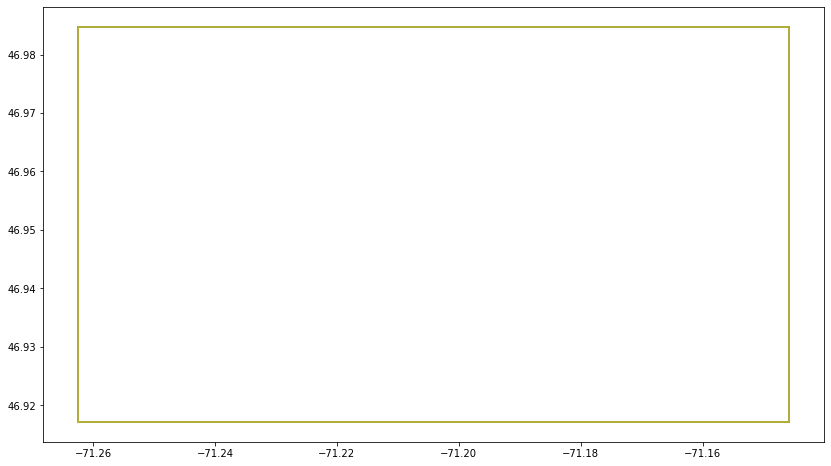

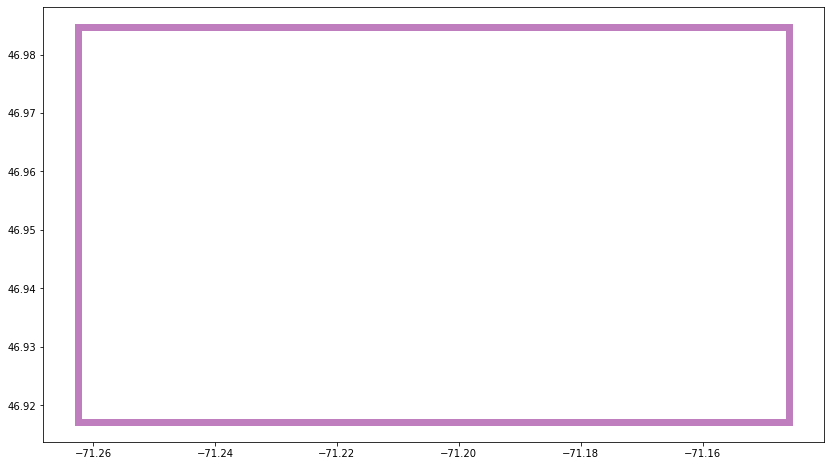

In [57]:
extent = create_full_extent(local_item_extents)

## 3. Create a STAC Collection to which append our STAC items 

Once we have our individual STAC items, we require somewhere to append them. To create a STAC collection we'll use the following parameters:

- ID: What we wish to call our collection.
- Title: Collection's title.
- Description: Details regarding the items within the collection.
- Extent: The spatial and temporal extent that we obtained from the create_full_extent function.
- Keywords: List of keywords describing the collection.
- Licence: Collection's license(s). (Set proprietary as the default)

If you wish to read up on STAC Collections follow this link: https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md


In [58]:
collection = pystac.Collection(id='Sentinel2_TEST_MK',
                               href='https://stac.geoanalytics.ca/collections',
                               title='Sentinel 2: Level 2a Test for Quebec City over the years of 2019 and 2020',
                               description="Sentinel 2: Level 2a imagery covering Quebec City for the years of 2019 and 2020. Provides imagery of 10, 20, and 60m resolution (band dependent).",
                               extent=extent,
                               keywords=['sentinel2', 'msi','esa'],
                               license='proprietary',)

In [ ]:
collection.describe()
collection.validate()

In [ ]:
collection.to_dict()

Now that we have the Collection, we need to add the STAC items to the collection. 

In [ ]:
for index, item in enumerate(local_stac_items):
    print(index)
    collection.add_item(item)

In [ ]:
collection.describe()
collection.validate()

## 4. Add our completed collection to the GeoAnalytics STAC Server

To add our collection to the GeoAnalytics STAC server all we'll need is our GeoAnalytics Authorization Token, the collection URL for GeoAnalytics, and our local collection.

- First upload the structure of the Collection itself. 
- Second upload the individual STAC Item to the collection in GeoAnalytics.

In [ ]:
# Add Items and Collection to STAC Server

auth_token = input("Please copy and paste your API Access Token here: ").strip()

To add to the STAC server we use requests.post(), and to make updates to existing items we use requests.put(). Let's finish up by adding our STAC collection and STAC items to the Server!

In [84]:
headers={'cookie': auth_token}
data = json.dumps(collection.to_dict())
r = requests.post('https://stac.geoanalytics.ca/collections/Sentinel2_TEST/', data=data, headers=headers)

In [ ]:
print(r)

In [ ]:
%%time
headers={'cookie': auth_token}
for index, stac_item in enumerate(local_stac_items):
    print(stac_item)
    data2 = json.dumps(stac_item.to_dict())
    r = requests.post('https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items', data=data2, headers=headers)
    print(r)

Now you know how to find data in a free STAC API, download it, and add it to your own STAC API for internal use. 
Don't forget to shutdown your clusters and close your client!

In [380]:
cluster.shutdown()
client.close()